<a href="https://colab.research.google.com/github/yusyrildwik/predictenergy/blob/main/Predict_Molecular_Energy%2C_XGB%2C_LGBM%2C_Random_Forest%2C_Stacked%2C_Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Thu Jul 20 14:55:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-6dc45b9a-94d7-4f8b-2fbd-b8328cc2f3fc)


In [ ]:
!lscpu |grep 'Model name'

Model name:                      Intel(R) Xeon(R) CPU @ 2.20GHz


In [ ]:
!free -h --si | awk  '/Mem:/{print $2}'

12G


In [ ]:
!wget --no-check-certificate \
    https://simpan.ugm.ac.id/s/VSejOaiJRfp30Mk/download \
    -O /tmp/predict-molecular-properties.zip

--2023-07-20 14:55:47--  https://simpan.ugm.ac.id/s/VSejOaiJRfp30Mk/download
Resolving simpan.ugm.ac.id (simpan.ugm.ac.id)... 175.111.88.197
Connecting to simpan.ugm.ac.id (simpan.ugm.ac.id)|175.111.88.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95524990 (91M) [application/zip]
Saving to: ‘/tmp/predict-molecular-properties.zip’

/tmp/predict-molecu 100%[===================>]  91.10M  38.7MB/s    in 2.4s    

2023-07-20 14:55:51 (38.7 MB/s) - ‘/tmp/predict-molecular-properties.zip’ saved [95524990/95524990]



Ektraksi Fitur Matriks Coloumb

In [ ]:
import zipfile, os
import json

local_zip = '/tmp/predict-molecular-properties.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/predict-molecular-properties')
zip_ref.close()
base_dir = '/tmp/predict-molecular-properties/'
with open('/tmp/predict-molecular-properties/pubChem_p_00000001_00025000.json') as f:
    data = json.load(f)

In [ ]:
periodic_table = {'H':[1, 1.0079],
                  'C':[6, 12.0107],
                  'N':[7, 14.0067],
                  'O':[8, 15.9994],
                  'S':[16, 32.065],
                  'F':[9, 18.9984],
                  'Si':[14, 28.0855],
                  'P':[15, 30.9738],
                  'Cl':[17, 35.453],
                  'Br':[35, 79.904],
                  'I': [53, 126.9045]}

In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform

natMax = 50 # jumlah atom maksimum
nMolecules = len(data)

data_CM = np.zeros((nMolecules, natMax * (natMax + 1) // 2), dtype=float)
data_ids = np.zeros(nMolecules, dtype=int)
data_multipoles = np.zeros((nMolecules, 14), dtype=float)
data_mmff94 = np.zeros(nMolecules, dtype=float)

ind = 0
for molecule in data:
  natoms = len(molecule['atoms'])
  if natoms > natMax:
    continue
  data_mmff94[ind] = molecule['En']
  data_multipoles[ind, :] = molecule['shapeM']
  data_ids[ind] = molecule['id']

  full_CM = np.zeros((natMax, natMax))
  full_Z = np.zeros(natMax)

  pos = []
  Z = []
  for i, at in enumerate(molecule['atoms']):
    Z.append(periodic_table[at['type']][0])
    pos.append(at['xyz'])

  pos = np.array(pos, dtype=float)
  Z = np.array(Z, dtype=float)

  tiny = 1e-20

  dm = pdist(pos)

  coulomb_matrix = np.outer(Z, Z) / (squareform(dm) + tiny)
  full_CM[0:natoms, 0:natoms] = coulomb_matrix
  full_Z[0:natoms] = Z

  iu = np.triu_indices(natMax, k=1)
  coulomb_vector = full_CM[iu]

  shuffle = np.argsort(-coulomb_vector)
  coulomb_vector = coulomb_vector[shuffle]

  coulomb_matrix = squareform(coulomb_vector)
  assert np.trace(coulomb_matrix) == 0, 'Matriks Coulomb tidak sesuai'

  coulomb_matrix += 0.5 * np.power(full_Z, 2.4) * np.eye(natMax)
  iu = np.triu_indices(natMax)
  feature_vector = coulomb_matrix[iu]
  assert feature_vector.shape[0] == natMax * (natMax + 1) // 2, 'Dimensi fitur tidak sesuai'

  data_CM[ind] = feature_vector

  ind += 1

dat = np.column_stack((data_CM, data_multipoles))
df = pd.DataFrame(dat)

numfeats = np.shape(dat)[1]
cols = [x for x in range(1, numfeats + 1, 1)]
col_names = list(map(lambda x: 'f' + str(x), cols))
df.columns = col_names

df.insert(0, 'pubchem_id', data_ids)
df['En'] = data_mmff94

In [ ]:
df.head()

,pubchem_id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f1281,f1282,f1283,f1284,f1285,f1286,f1287,f1288,f1289,En
0,1,73.516695,39.230740,38.058812,37.934254,35.169765,33.617995,28.032659,27.705090,27.600070,...,2.55,0.16,-3.13,-0.22,-2.18,-0.56,0.21,0.17,0.09,37.8010
1,2,73.516695,39.230539,39.213259,35.384864,35.171945,33.606458,28.271514,28.154189,27.704183,...,0.81,0.05,-0.40,-0.71,-2.51,-0.17,0.01,-0.33,-0.13,44.1107
2,3,73.516695,39.420140,35.571151,33.601772,33.564165,27.985222,26.861051,26.852468,24.963419,...,0.23,0.02,0.08,-0.70,-0.26,0.20,-0.29,-0.35,-0.34,19.4085
3,4,73.516695,33.629161,28.836604,23.630536,23.518647,20.151961,19.963944,16.945914,15.112884,...,0.25,0.00,-0.04,0.01,-0.48,-0.08,0.00,0.01,0.07,-0.1086
4,5,332.344906,79.959785,74.207114,74.205076,74.014645,38.987518,34.468622,33.988388,28.915828,...,0.15,0.00,0.07,-0.03,-0.25,0.00,-0.63,-0.27,0.01,-23.8799


In [ ]:
df.shape

(18205, 1291)

In [ ]:
path = 'molecules_' + '1' + '_' + '25000' + '.csv'
df.to_csv(path)

In [ ]:
path = 'molecules_' + '1' + '_' + '25000' + '.csv'
df.to_csv(path)

Import Pustaka

In [ ]:
!wget --no-check-certificate \
    https://simpan.ugm.ac.id/s/mXmKQxTXyyrzRJr/download \
    -O /tmp/energy-molecule.zip

!wget --no-check-certificate \
    https://simpan.ugm.ac.id/s/KEp0BrgNystnmmA/download \
    -O /tmp/coulombL.csv

--2023-07-20 14:56:59--  https://simpan.ugm.ac.id/s/mXmKQxTXyyrzRJr/download
Resolving simpan.ugm.ac.id (simpan.ugm.ac.id)... 175.111.88.197
Connecting to simpan.ugm.ac.id (simpan.ugm.ac.id)|175.111.88.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52083703 (50M) [application/zip]
Saving to: ‘/tmp/energy-molecule.zip’

/tmp/energy-molecul 100%[===================>]  49.67M  23.5MB/s    in 2.1s    

2023-07-20 14:57:03 (23.5 MB/s) - ‘/tmp/energy-molecule.zip’ saved [52083703/52083703]

--2023-07-20 14:57:03--  https://simpan.ugm.ac.id/s/KEp0BrgNystnmmA/download
Resolving simpan.ugm.ac.id (simpan.ugm.ac.id)... 175.111.88.197
Connecting to simpan.ugm.ac.id (simpan.ugm.ac.id)|175.111.88.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7756187 (7.4M) [text/csv]
Saving to: ‘/tmp/coulombL.csv’

/tmp/coulombL.csv   100%[===================>]   7.40M  6.47MB/s    in 1.1s    

2023-07-20 14:57:04 (6.47 MB/s) - ‘/tmp/coulombL.csv’ saved 

In [ ]:
import zipfile, os
local_zip = '/tmp/energy-molecule.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/energy-molecule')
zip_ref.close()
base_dir = '/tmp/energy-molecule/'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import Ridge
from xgboost.sklearn import XGBRegressor
from xgboost import plot_tree
from lightgbm.sklearn import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, make_scorer
from sklearn.decomposition import PCA
import time
sns.set()

Eksplorasi Data

In [ ]:
df = pd.read_csv('/tmp/energy-molecule/roboBohr.csv')
coulombl = pd.read_csv('/tmp/coulombL.csv', header=None, index_col=0)

In [ ]:
df.shape

(16242, 1278)

In [ ]:
df.columns.values

array(['Unnamed: 0', '0', '1', ..., '1274', 'pubchem_id', 'Eat'],
      dtype=object)

In [ ]:
df

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1267,1268,1269,1270,1271,1272,1273,1274,pubchem_id,Eat
0,0,73.516695,17.817765,12.469551,12.458130,12.454607,12.447345,12.433065,12.426926,12.387474,...,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,25004,-19.013763
1,1,73.516695,20.649126,18.527789,17.891535,17.887995,17.871731,17.852586,17.729842,15.864270,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25005,-10.161019
2,2,73.516695,17.830377,12.512263,12.404775,12.394493,12.391564,12.324461,12.238106,10.423249,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25006,-9.376619
3,3,73.516695,17.875810,17.871259,17.862402,17.850920,17.850440,12.558105,12.557645,12.517583,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25009,-13.776438
4,4,73.516695,17.883818,17.868256,17.864221,17.818540,12.508657,12.490519,12.450098,10.597068,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25011,-8.537140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16237,16268,73.516695,20.753166,18.624076,17.872009,17.851690,17.851254,17.742176,14.655754,12.706683,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74976,-8.876123
16238,16269,73.516695,20.724740,18.579933,17.741621,14.716676,13.697829,13.697558,13.653512,13.652942,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74977,-13.105268
16239,16270,53.358707,20.820797,19.150234,19.148721,15.135514,15.123685,12.942704,12.938162,12.488633,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74978,-16.801464
16240,16271,53.358707,15.707759,15.707644,13.653838,13.653570,13.653314,13.652591,13.652585,13.652550,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74979,-13.335088


In [ ]:
df = df.drop(['Unnamed: 0', 'pubchem_id'], axis=1)

In [ ]:
df.isnull().sum().sum()

0

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,...,1266,1267,1268,1269,1270,1271,1272,1273,1274,Eat
0,73.516695,17.817765,12.469551,12.458130,12.454607,12.447345,12.433065,12.426926,12.387474,12.365984,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,-19.013763
1,73.516695,20.649126,18.527789,17.891535,17.887995,17.871731,17.852586,17.729842,15.864270,15.227643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-10.161019
2,73.516695,17.830377,12.512263,12.404775,12.394493,12.391564,12.324461,12.238106,10.423249,8.698826,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9.376619
3,73.516695,17.875810,17.871259,17.862402,17.850920,17.850440,12.558105,12.557645,12.517583,12.444141,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-13.776438
4,73.516695,17.883818,17.868256,17.864221,17.818540,12.508657,12.490519,12.450098,10.597068,10.595914,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.537140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16237,73.516695,20.753166,18.624076,17.872009,17.851690,17.851254,17.742176,14.655754,12.706683,12.557785,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.876123
16238,73.516695,20.724740,18.579933,17.741621,14.716676,13.697829,13.697558,13.653512,13.652942,13.652387,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-13.105268
16239,53.358707,20.820797,19.150234,19.148721,15.135514,15.123685,12.942704,12.938162,12.488633,12.488061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-16.801464
16240,53.358707,15.707759,15.707644,13.653838,13.653570,13.653314,13.652591,13.652585,13.652550,12.743890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-13.335088


In [ ]:
df['Eat'].describe()

count    16242.000000
mean       -11.178969
std          3.659133
min        -23.245373
25%        -13.475805
50%        -10.835211
75%         -8.623903
max         -0.789513
Name: Eat, dtype: float64

<ipython-input-24-2f4ea3f5bbef>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Eat'], kde=True)


Text(0.5, 1.0, 'Distribusi Energi Atomisasi')

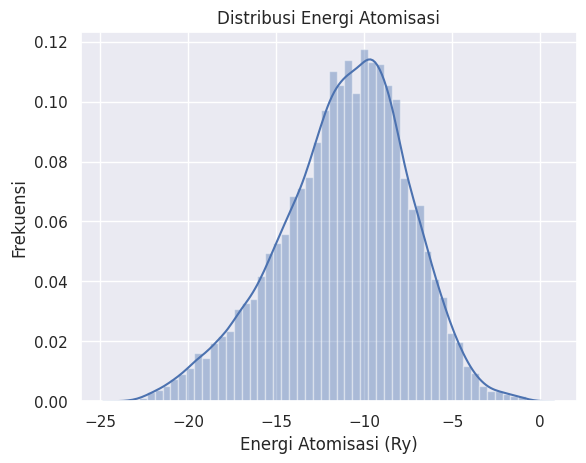

In [ ]:
sns.distplot(df['Eat'], kde=True)
plt.xlabel('Energi Atomisasi (Ry)')
plt.ylabel('Frekuensi')
plt.title('Distribusi Energi Atomisasi')

PCA

In [ ]:
pca = PCA(n_components=2)
z = pca.fit_transform(coulombl)
z = pd.DataFrame(z)

Text(0.5, 1.0, 'Energi Atomisasi sebagai fungsi dua komponen PCA (z1, z2)')

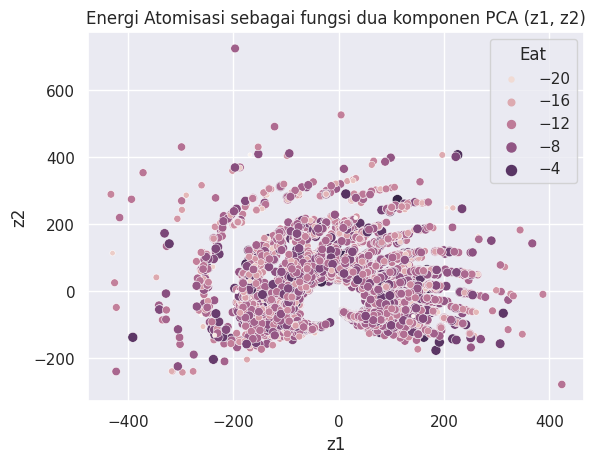

In [ ]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
ax = sns.scatterplot(x=-z[0], y=z[1],
                     size=df['Eat'], hue=df['Eat'],
                     palette=cmap, sizes=(5, 60))
plt.xlabel('z1')
plt.ylabel('z2')
plt.title('Energi Atomisasi sebagai fungsi dua komponen PCA (z1, z2)')

In [ ]:
# z.rename(columns={0:'pca_0', 1:'pca_1'}, inplace=True)
# df = pd.concat([df, z], axis=1, sort=False)

Split Dataset

In [ ]:
X = df.drop(['Eat'], axis=1)
Y = df['Eat']

X = X.values
Y = Y.values
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

Model XGB

In [ ]:
xgb = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    eta = 0.0629,
    reg_lambda=0,
    max_depth=6,
    colsample_bytree=0.2,
    min_child_weight=10,
    n_estimators=400)

In [ ]:
def rmse_fun(predicted, actual):
  return np.sqrt(np.mean(np.square(predicted - actual)))

In [ ]:
start_time = time.time()

rmse = make_scorer(rmse_fun, greater_is_better=False)
xgb_score = -1.0 * cross_val_score(xgb, x_train, y_train, scoring=rmse, cv=5)
xgb_scores = np.mean(xgb_score)
print(xgb_score)
print(xgb_scores)

print("--- %s seconds ---" % (time.time() - start_time))

[0.10155019 0.0883036  0.09146245 0.09114182 0.0904969 ]
0.0925909918147735
--- 401.9806752204895 seconds ---


In [ ]:
start_time = time.time()
xgb.fit(x_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 93.69628953933716 seconds ---


In [ ]:
start_time = time.time()
y_pred_xgb = xgb.predict(x_test)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.07268404960632324 seconds ---


In [ ]:
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print('MAE:', mean_absolute_error(y_test, y_pred_xgb))
print('Test Accuracy:', xgb.score(x_test, y_test))

RMSE: 0.08853905038168097
MAE: 0.054262045211519366
Test Accuracy: 0.9994009671448125


In [ ]:
print(pd.DataFrame({'Sumber':['Data uji', 'Hasil prediksi'], 'Rata-rata E':[y_pred_xgb.mean(), y_test.mean()]}))

           Sumber  Rata-rata E
0        Data uji   -11.145680
1  Hasil prediksi   -11.142934


<ipython-input-36-6732860296b6>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_xgb, ax=ax[0], color='green', label='validation xgb')
<ipython-input-36-6732860296b6>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test, ax=ax[1], color='red', label='test')


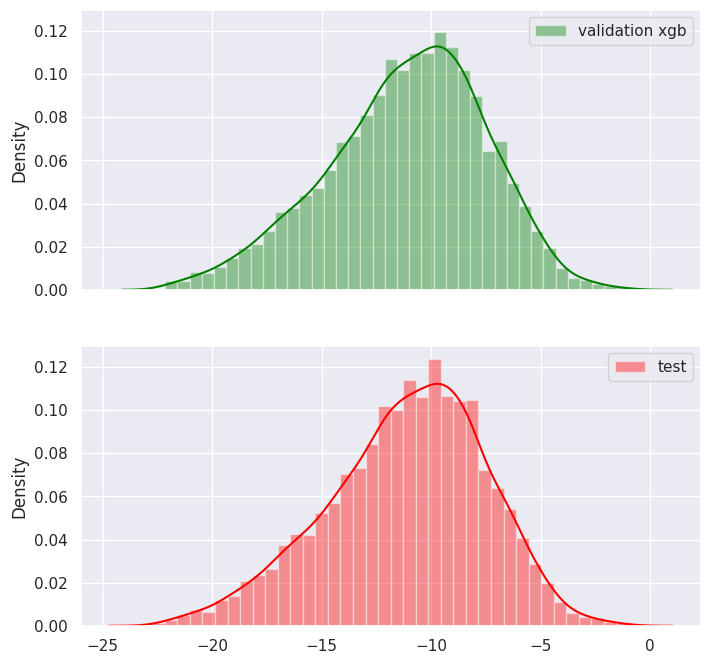

In [ ]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(8, 8))
sns.distplot(y_pred_xgb, ax=ax[0], color='green', label='validation xgb')
sns.distplot(y_test, ax=ax[1], color='red', label='test')
ax[0].legend(loc=0)
ax[1].legend(loc=0)
plt.show()

Model LightGBM

In [ ]:
lgbm = LGBMRegressor(
      objective = 'regression',
      num_leaves = 31,
      n_estimators = 250,
      min_child_weight = 0.001,
      max_depth = -1,
      learning_rate = 0.1,
      colsample_bytree = 1.0 )

In [ ]:
start_time = time.time()

rmse = make_scorer(rmse_fun, greater_is_better=False)
lgbm_scores = -1.0 * cross_val_score(lgbm, x_train, y_train, scoring=rmse, cv=5).mean()
print(lgbm_scores)

print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
start_time = time.time()
lgbm.fit(x_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
start_time = time.time()
y_pred_lgbm = lgbm.predict(x_test)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_lgbm)))
print('MAE:', mean_absolute_error(y_test, y_pred_lgbm))
print('Test Accuracy:', lgbm.score(x_test, y_test))

In [ ]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(8, 8))
sns.distplot(y_pred_lgbm, ax=ax[0], color='orange', label='validation Lightgbm')
sns.distplot(y_test, ax=ax[1], color='red', label='test')
ax[0].legend(loc=0)
ax[1].legend(loc=0)
plt.show()

Model Random Forest

In [ ]:
rf = RandomForestRegressor(
    n_estimators = 100,
    criterion = 'squared_error',
    min_samples_split = 3,
    max_features = 'auto',
    max_depth = 8)

In [ ]:
start_time = time.time()

rmse = make_scorer(rmse_fun, greater_is_better=False)
rf_scores = -1.0 * cross_val_score(rf, x_train, y_train, scoring=rmse, cv=5).mean()
print(rf_scores)

print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
start_time = time.time()
rf.fit(x_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
start_time = time.time()
y_pred_rf = rf.predict(x_test)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print('MAE:', mean_absolute_error(y_test, y_pred_rf))
print('Test Accuracy:', rf.score(x_test, y_test))

In [ ]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(8, 8))
sns.distplot(y_pred_rf, ax=ax[0], color='grey', label='validation RF')
sns.distplot(y_test, ax=ax[1], color='red', label='test')
ax[0].legend(loc=0)
ax[1].legend(loc=0)
plt.show()

Stacking Generalization

In [ ]:
from mlxtend.regressor import StackingCVRegressor

Ridge=

stacked_model = StackingCVRegressor(
      regressors=[xgb, lgbm],
      meta_regressor=Ridge())

In [ ]:
start_time = time.time()

rmse = make_scorer(rmse_fun, greater_is_better=False)
stacked_score = -1.0 * cross_val_score(stacked_model, x_train, y_train, scoring=rmse, cv=5).mean()
print(stacked_score)

print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
start_time = time.time()
stacked_model.fit(x_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
start_time = time.time()
y_pred_stacked = stacked_model.predict(x_test)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_stacked)))
print('MAE:', mean_absolute_error(y_test, y_pred_stacked))
print('Test Accuracy:', stacked_model.score(x_test, y_test))

In [ ]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(8, 8))
sns.distplot(y_pred_stacked, ax=ax[0], color='blue', label='validation stacked')
sns.distplot(y_test, ax=ax[1], color='red', label='test')
ax[0].legend(loc=0)
ax[1].legend(loc=0)
plt.show()

Perbandingan Hasil

In [ ]:
print(pd.DataFrame({'Model':['XGB', 'LightGBM', 'Random Forest', 'Stacked'],
                    'MAE':[mean_absolute_error(y_test, y_pred_xgb),mean_absolute_error(y_test, y_pred_lgbm), mean_absolute_error(y_test, y_pred_rf), mean_absolute_error(y_test, y_pred_stacked)],
                    'RMSE':[np.sqrt(mean_squared_error(y_test, y_pred_xgb)), np.sqrt(mean_squared_error(y_test, y_pred_lgbm)), np.sqrt(mean_squared_error(y_test, y_pred_rf)), np.sqrt(mean_squared_error(y_test, y_pred_stacked))]}))

In [ ]:
print(pd.DataFrame({'Model':['XGB', 'LightGBM', 'Random Forest', 'Stacked', 'Data uji'],
                    'Rata-rata E':[y_pred_xgb.mean(), y_pred_lgbm.mean(), y_pred_rf.mean(), y_pred_stacked.mean(), y_test.mean()]
                    }))

In [ ]:
fig2, ax2 = plt.subplots(nrows=5, sharex=True, sharey=True, figsize=(8,8))
sns.distplot(y_pred_xgb, ax=ax2[0], color='green', label='validation xgb')
sns.distplot(y_pred_lgbm, ax=ax2[1], color='orange', label='validation lgbm')
sns.distplot(y_pred_rf, ax=ax2[2], color='grey', label='validation rf')
sns.distplot(y_test, ax=ax2[3], color='red', label='test')
ax2[0].legend(loc=0)
ax2[1].legend(loc=0)
ax2[2].legend(loc=0)
ax2[3].legend(loc=0)
plt.show()

In [ ]:
fig2, ax2 = plt.subplots(nrows=5, sharex=True, sharey=True, figsize=(8,8))
sns.distplot(y_pred_xgb, ax=ax2[0], color='green', label='validation xgb')
sns.distplot(y_pred_lgbm, ax=ax2[1], color='orange', label='validation lgbm')
sns.distplot(y_pred_rf, ax=ax2[2], color='grey', label='validation rf')
sns.distplot(y_pred_stacked, ax=ax2[3], color='blue', label='validation stacked')
sns.distplot(y_test, ax=ax2[4], color='red', label='test')
ax2[0].legend(loc=0)
ax2[1].legend(loc=0)
ax2[2].legend(loc=0)
ax2[3].legend(loc=0)
ax2[4].legend(loc=0)
plt.show()

In [ ]:
a = y_test - y_pred_xgb
a.shape

In [ ]:
y_test

In [ ]:
y_pred_xgb

In [ ]:
g = sns.displot(y_test - y_pred_xgb, kde=True)
g.set_axis_labels('Ralat (Ry)')
g = sns.displot(y_test - y_pred_lgbm, kde=True)
g.set_axis_labels('Ralat (Ry)')
g = sns.displot(y_test - y_pred_rf, kde=True)
g.set_axis_labels('Ralat (Ry)')
g = sns.displot(y_test - y_pred_stacked, kde=True)
g.set_axis_labels('Ralat (Ry)')